#### MOUNTING GOOGLE DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### UNZIPPING DATASET ZIP UPLOADED IN DRIVE

In [2]:
import os

ass2_path = "\"drive/MyDrive/Colab Notebooks/Intro_to_ML/Assigment_2\""
path_to_zip = os.path.join(ass2_path, "cnn_dataset.zip")
!unzip -q -o {path_to_zip}


#### IMPORTING ALL THE REQUIRED LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
!pip install torchinfo
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.image as mpimg
import torchvision
import seaborn as sns
import random
from itertools import cycle
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import time
!pip install torchmetrics
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision import datasets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix, auc
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import time
import torch
from torchmetrics import Accuracy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.8 MB/s eta 0:00:00


#### Splitting the dataset into test , train and validation dataset

In [4]:
data_directory = "/content/cnn_dataset"
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image_dataset = datasets.ImageFolder(root=data_directory, transform= transform)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [int(0.8 * len(image_dataset)), int(0.1 * len(image_dataset)), len(image_dataset) - int(0.8 * len(image_dataset)) - int(0.1 * len(image_dataset))])

#### Loading the dataset into train_loader , val_loader and test_loader

In [5]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

number_of_classes = len(image_dataset.classes)
print(f"Number of classes: {number_of_classes}")



Number of classes: 36


#### Training and Testing the model

In [6]:
import time
import torch
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy


# loss function : crossentropy

def loss_function(predictions, labels):
    return nn.CrossEntropyLoss()(predictions, labels)



# testing the model

def test_model(test_loader, model):
    total_test_loss = 0.0
    test_predictions = []
    true_test_labels = []
    with torch.no_grad():
      for data, labels in test_loader:
          # Forward pass
          predictions = model(data)
          # Calculating the loss
          total_test_loss += loss_function(predictions, labels).item()
          # Collect predictions and true labels
          _, predicted = torch.max(predictions, 1)
          test_predictions.extend(predicted.numpy())
          true_test_labels.extend(labels.numpy())
    accuracy = Accuracy(task="multiclass", num_classes=36)
    test_acc_value = accuracy(torch.tensor(test_predictions), torch.tensor(true_test_labels))
    average_test_loss = total_test_loss / len(test_loader)
    precision, recall, f1, extra = precision_recall_fscore_support(true_test_labels, test_predictions, average='macro')
    print(f'Test Accuracy:{test_acc_value * 100}%')
    print(f'Avg Test Loss:{average_test_loss}')
    print(f'Precision: {precision:}  | Recall: {recall:} | F1 Score: {f1:}')
    return average_test_loss, test_acc_value, precision, recall, f1, test_predictions, true_test_labels



# taring the model  and evaluating on the train_loader and validation loader

def train_model(train_loader,val_loader,test_loader, model, num_epochs):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # defining the optimiser

    optimizer = optim.Adam(vgg_model.parameters(), lr=0.0001)

    # for each epoch

    for epoch in range(num_epochs):
        print(f'In Epoch {epoch + 1}')

        # Training
        model.train()
        total_train_loss = 0.0
        train_predictions = []
        true_train_labels = []

        # each batch in train loader
        for data, labels in train_loader:
            # Forward pass
            predictions = model(data)
            # calculating the  loss
            loss = loss_function(predictions, labels)
            total_train_loss += loss.item()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Collect predictions and true labels
            _, predicted = torch.max(predictions, 1)
            train_predictions.extend(predicted.numpy())
            true_train_labels.extend(labels.numpy())

        accuracy = Accuracy(task="multiclass", num_classes=36)
        train_acc_value = accuracy(torch.tensor(train_predictions), torch.tensor(true_train_labels))
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(train_acc_value)
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_acc_value * 100:.2f}%")

        # model in evaluation mode
        total_val_loss = 0.0
        val_predictions = []
        val_true_labels = []
        model.eval()
        with torch.no_grad():
            for data, labels in val_loader:
                predictions = model(data)
                val_loss = loss_function(predictions, labels)
                total_val_loss += val_loss.item()

                # Collect predictions and true labels
                _, predicted = torch.max(predictions, 1)
                val_predictions.extend(predicted.numpy())
                val_true_labels.extend(labels.numpy())

        accuracy = Accuracy(task="multiclass", num_classes=36)
        val_acc_value = accuracy(torch.tensor(val_predictions), torch.tensor(val_true_labels))
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(val_acc_value)

        print(f"Validation Loss: {val_losses[-1]} | Validation Accuracy: {val_acc_value * 100}%")
    average_test_loss, test_acc_value, precision, recall, f1, test_predictions, true_test_labels = test_model(test_loader, model)
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc_value, precision, recall, f1, test_predictions, true_test_labels, average_test_loss


In [7]:
class VGG11(nn.Module):
    def __init__(self, num_classes=36):
        super(VGG11, self).__init__()

        # defining the classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # defining teh features
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    # forward step
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

vgg_model = VGG11()

train_loss_list, val_loss_list, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, test_predictions, all_true_labels_test, test_loss = train_model(train_loader, val_loader, test_loader, vgg_model,3)



In Epoch 1
Trainining Loss: 1.5015 | Training Accuracy: 50.96%
Validation Loss: 0.4419917849988877 | Validation Accuracy: 84.62301635742188%
In Epoch 2
Trainining Loss: 0.3792 | Training Accuracy: 86.49%
Validation Loss: 0.30463581334186507 | Validation Accuracy: 89.0079345703125%
In Epoch 3
Trainining Loss: 0.2895 | Training Accuracy: 89.44%
Validation Loss: 0.30513128128987327 | Validation Accuracy: 88.95833587646484%
Test Accuracy: 88.98809814453125%
Average Test Loss: 0.3024437941988058
Precision: 0.90  | Recall: 0.89 | F1 Score: 0.89


#### Printing the summary of model

In [8]:
# printing the summary of model
summary(vgg_model)

Layer (type:depth-idx)                   Param #
VGG11                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,101,248
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       16,781,312
│    └─ReLU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       147,492
├─Sequential: 1-2                        --
│    └─Conv2d: 2-8                       640
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      73,856
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
│    └─Conv2d: 2-14                      295,168
│    └─ReLU: 2-15                        --
│    └─Conv2d: 2-16                      590,080
│    └─ReLU: 2-17                        --
│    └─MaxPool2d: 2-18              

#### Saving the weights for the model

In [9]:
weights = vgg_model.state_dict()
torch.save(weights, 'lsreeram_rohanmoh_assignment2_part4.h5')

In [10]:
# testing once again as values returned and values assigned are not matching

average_test_loss, test_acc_value, precision, recall, f1, test_predictions, true_test_labels = test_model(test_loader, vgg_model)

Test Accuracy: 88.98809814453125%
Average Test Loss: 0.3024437941988058
Precision: 0.90  | Recall: 0.89 | F1 Score: 0.89


#### Plotting graphs for test , train and validation accuracies

[tensor(0.5096), tensor(0.8649), tensor(0.8944)]
[tensor(0.8462), tensor(0.8901), tensor(0.8896)]
tensor(0.8899)


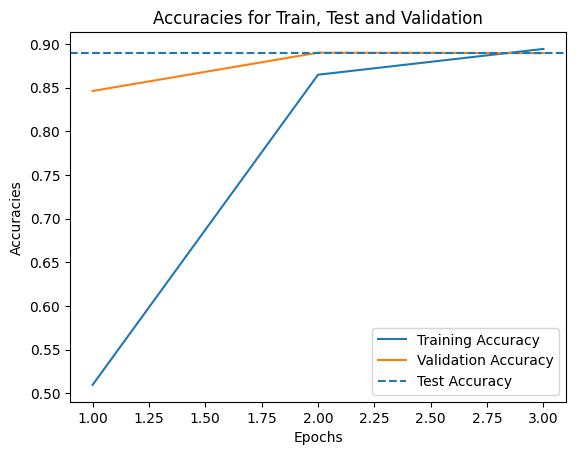

In [11]:
epochs_range = range(1, 4)
print(train_accuracies)
print(val_accuracies)
print(test_accuracy)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.axhline(y= test_acc_value, linestyle='--', label='Test Accuracy')
plt.ylabel('Accuracies')
plt.xlabel('Epochs')
plt.title('Accuracies for Train, Test and Validation')
plt.legend()
plt.show()


In [12]:
print(len(test_predictions))
print(len(true_test_labels))

10080
10080


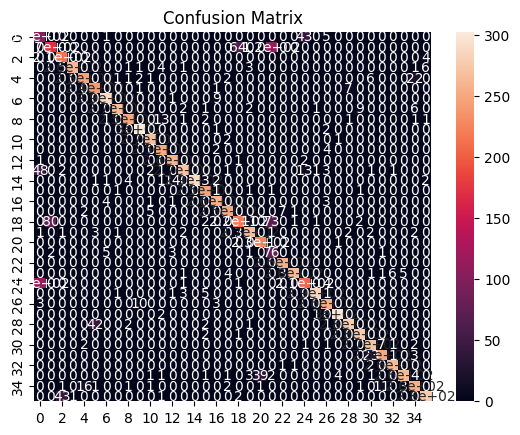

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
label_encoder = LabelEncoder()
label_encoder.fit(true_test_labels)

# Transform the test data labels into a binary array.
confusion_matrix = confusion_matrix(test_predictions, true_test_labels)

sns.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix")
plt.show()
